<a href="https://colab.research.google.com/github/daniellemosborne/Plant_Classification/blob/main/Plant_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification Model

# Objective

The goal of this project is to build a deep learning model that can classify images of plants and flowers into distinct classes using a dataset of PNG images.

**Training our model from two separate datasets:**
*   Flowers (16 types)
*   Leaves (22 types)



In [ ]:
from tensorflow import keras

model_flowerbase = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

In [ ]:
model_plantbase = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

In [ ]:
model_flowerbase.trainable = False
model_plantbase.trainable = False

In [ ]:
inputs_flower = keras.Input(shape=(224, 224, 3))
x_flower = model_flowerbase(inputs_flower, training=False)
x_flower = keras.layers.GlobalAveragePooling2D()(x_flower)
x_flower = keras.layers.Dense(512, activation='relu')(x_flower)
outputs_flower = keras.layers.Dense(16)(x_flower) # 16 flower classes
model_flower = keras.Model(inputs_flower, outputs_flower)

In [ ]:
model_flower.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 16)                8208      
                                                                 
Total params: 14985552 (57.17 MB)
Trainable params: 270864 (1.03 MB)
Non-trainable params: 14714688 (56.13 MB)
________________

In [ ]:
inputs_plant = keras.Input(shape=(224, 224, 3))
x_plant = model_plantbase(inputs_plant, training=False)
x_plant = keras.layers.GlobalAveragePooling2D()(x_plant)
x_plant = keras.layers.Dense(512, activation='relu')(x_plant)
outputs_plant = keras.layers.Dense(22)(x_plant) # 22 plant classes
model_plant = keras.Model(inputs_plant, outputs_plant)

In [ ]:
model_plant.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 22)                11286     
                                                                 
Total params: 14988630 (57.18 MB)
Trainable params: 273942 (1.05 MB)
Non-trainable params: 14714688 (56.13 MB)
______________

Compiling the Model

As with our previous exercises, we need to compile the model with loss and metrics options. We have to make some different choices here. In previous cases we had many categories in our classification problem. As a result, we picked categorical crossentropy for the calculation of our loss. In this case we only have a binary classification problem (Bo or not Bo), and so we will use binary crossentropy. Further detail about the differences between the two can found here. We will also use binary accuracy instead of traditional accuracy.

By setting from_logits=True we inform the loss function that the output values are not normalized (e.g. with softmax).

In [ ]:
model_flower.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.CategoricalAccuracy()])
model_plant.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.CategoricalAccuracy()])

Augmenting the Data

Now that we are dealing with a very small dataset, it is especially important that we augment our data. As before, we will make small modifications to the existing images, which will allow the model to see a wider variety of images to learn from. This will help it learn to recognize new pictures of Bo instead of just memorizing the pictures it trains on.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
flower_train_datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True) # can be vertically flipped

flower_valid_datagen = ImageDataGenerator(
        samplewise_center=True,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True)

# create a data generator
plant_train_datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True) # can be vertically flipped

plant_valid_datagen = ImageDataGenerator(
        samplewise_center=True,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True)

Loading the Data

We have seen datasets in a couple different formats so far. In the MNIST exercise, we were able to download the dataset directly from within the Keras library. For the sign language dataset, the data was in CSV files. For this exercise, we are going to load images directly from folders using Keras' flow_from_directory function. We have set up our directories to help this process go smoothly as our labels are inferred from the folder names. In the data/presidential_doggy_door directory, we have train and validation directories, which each have folders for images of Bo and not Bo. In the not_bo directories, we have pictures of other dogs and cats, to teach our model to keep out other pets. Feel free to explore the images to get a sense of our dataset.

Note that flow_from_directory will also allow us to size our images to match the model: 244x244 pixels with 3 channels.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/datasets.zip' -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/flowers/train/water_lily/50180378431_d2825b181b_c.jpg  
  inflating: /content/data/flowers/train/water_lily/50185423763_b5f2341f37_c.jpg  
  inflating: /content/data/flowers/train/water_lily/50185504777_d764d5b4eb_c.jpg  
  inflating: /content/data/flowers/train/water_lily/50187533448_e41685bcc1_c.jpg  
  inflating: /content/data/flowers/train/water_lily/50193663533_a4710da908_c.jpg  
  inflating: /content/data/flowers/train/water_lily/50193671482_426aa49abc_c.jpg  
  inflating: /content/data/flowers/train/water_lily/50198314188_7a19145530_c.jpg  
  inflating: /content/data/flowers/train/water_lily/50202818411_55c5174fd5_c.jpg  
  inflating: /content/data/flowers/train/water_lily/50203113423_1e97b91f51_c.jpg  
  inflating: /content/data/flowers/train/water_lily/50203783366_18242a9022_c.jpg  
  inflating: /content/data/flowers/train/water_lily/50208629661_55d3967b13_c.jpg  
  inflating: /content/data/flowers/t

In [ ]:
# Load and iterate training dataset for flowers
train_flowers = flower_train_datagen.flow_from_directory('data/flowers/train',
                                       target_size=(224, 224),
                                       color_mode='rgb',
                                       class_mode='categorical',
                                       batch_size=8)

# Load and iterate validation dataset for flowers
valid_flowers = flower_valid_datagen.flow_from_directory('data/flowers/valid',
                                      target_size=(224, 224),
                                      color_mode='rgb',
                                      class_mode='categorical',
                                      batch_size=8)

# Load and iterate training dataset for plants
train_plants = plant_train_datagen.flow_from_directory('data/plants/train',
                                       target_size=(224, 224),
                                       color_mode='rgb',
                                       class_mode='categorical',
                                       batch_size=8)

# Load and iterate validation dataset for plants
valid_plants = plant_valid_datagen.flow_from_directory('data/plants/valid',
                                      target_size=(224, 224),
                                      color_mode='rgb',
                                      class_mode='categorical',
                                      batch_size=8)

Found 15570 images belonging to 16 classes.
Found 80 images belonging to 16 classes.
Found 4274 images belonging to 22 classes.
Found 110 images belonging to 22 classes.


Training the Model

Time to train our model and see how it does. Recall that when using a data generator, we have to explicitly set the number of steps_per_epoch:

In [ ]:
# Train flowers model
model_flower.fit(train_flowers, steps_per_epoch=24, validation_data=valid_flowers, validation_steps=8, epochs=20)

Epoch 1/20
24/24 [==============================] - 161s 7s/step - loss: 5.5996 - categorical_accuracy: 0.2604 - val_loss: 2.7584 - val_categorical_accuracy: 0.4062
Epoch 2/20
24/24 [==============================] - 157s 7s/step - loss: 3.1343 - categorical_accuracy: 0.3385 - val_loss: 1.6310 - val_categorical_accuracy: 0.5625
Epoch 3/20
24/24 [==============================] - 157s 7s/step - loss: 2.1763 - categorical_accuracy: 0.4740 - val_loss: 1.9142 - val_categorical_accuracy: 0.5156
Epoch 4/20
24/24 [==============================] - 198s 8s/step - loss: 1.7191 - categorical_accuracy: 0.5156 - val_loss: 2.4073 - val_categorical_accuracy: 0.5625
Epoch 5/20
24/24 [==============================] - 156s 7s/step - loss: 1.6061 - categorical_accuracy: 0.5990 - val_loss: 1.0400 - val_categorical_accuracy: 0.7188
Epoch 6/20
24/24 [==============================] - 151s 6s/step - loss: 1.4168 - categorical_accuracy: 0.6613 - val_loss: 1.7921 - val_categorical_accuracy: 0.5625
Epoch 7/20

In [ ]:
# Train plants model
model_plant.fit(train_plants, steps_per_epoch=24, validation_data=valid_plants, validation_steps=8, epochs=20)

Epoch 1/20
24/24 [==============================] - 226s 9s/step - loss: 3.6460 - categorical_accuracy: 0.2031 - val_loss: 2.6323 - val_categorical_accuracy: 0.3125
Epoch 2/20
24/24 [==============================] - 216s 9s/step - loss: 1.8185 - categorical_accuracy: 0.4355 - val_loss: 2.1383 - val_categorical_accuracy: 0.4062
Epoch 3/20
24/24 [==============================] - 222s 9s/step - loss: 1.5721 - categorical_accuracy: 0.5104 - val_loss: 1.6049 - val_categorical_accuracy: 0.5469
Epoch 4/20
24/24 [==============================] - 225s 9s/step - loss: 1.4446 - categorical_accuracy: 0.5625 - val_loss: 1.8944 - val_categorical_accuracy: 0.4844
Epoch 5/20
24/24 [==============================] - 215s 9s/step - loss: 1.2005 - categorical_accuracy: 0.6302 - val_loss: 1.3866 - val_categorical_accuracy: 0.5938
Epoch 6/20
24/24 [==============================] - 218s 9s/step - loss: 1.1222 - categorical_accuracy: 0.6615 - val_loss: 1.1892 - val_categorical_accuracy: 0.5781
Epoch 7/20

Fine-Tuning the Model

Now that the new layers of the model are trained, we have the option to apply a final trick to improve the model, called fine-tuning. To do this we unfreeze the entire model, and train it again with a very small learning rate. This will cause the base pre-trained layers to take very small steps and adjust slightly, improving the model by a small amount.

Note that it is important to only do this step after the model with frozen layers has been fully trained. The untrained pooling and classification layers that we added to the model earlier were randomly initialized. This means they needed to be updated quite a lot to correctly classify the images. Through the process of backpropagation, large initial updates in the last layers would have caused potentially large updates in the pre-trained layers as well. These updates would have destroyed those important pre-trained features. However, now that those final layers are trained and have converged, any updates to the model as a whole will be much smaller (especially with a very small learning rate) and will not destroy the features of the earlier layers.

Let's try unfreezing the pre-trained layers, and then fine tuning the model:

In [ ]:
# Unfreeze the base model
model_flowerbase.trainable = True
model_plantbase.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model_flower.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              #loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])
              #metrics=[keras.metrics.BinaryAccuracy()])

model_plant.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              #loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])
              #metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
flower_accuracies = []
plant_accuracies = []

history_flowers = model_flower.fit(train_flowers, steps_per_epoch=24, validation_data=valid_flowers, validation_steps=8, epochs=14)
flower_accuracies.append(history_flowers.history['categorical_accuracy'])

history_plants = model_plant.fit(train_plants, steps_per_epoch=24, validation_data=valid_plants, validation_steps=8, epochs=14)
plant_accuracies.append(history_plants.history['categorical_accuracy'])

Epoch 1/14
24/24 [==============================] - 441s 18s/step - loss: 0.8373 - categorical_accuracy: 0.7396 - val_loss: 0.6282 - val_categorical_accuracy: 0.7812
Epoch 2/14
24/24 [==============================] - 427s 18s/step - loss: 0.8973 - categorical_accuracy: 0.7865 - val_loss: 0.5347 - val_categorical_accuracy: 0.8125
Epoch 3/14
24/24 [==============================] - 412s 17s/step - loss: 0.8541 - categorical_accuracy: 0.7396 - val_loss: 0.6185 - val_categorical_accuracy: 0.8281
Epoch 4/14
24/24 [==============================] - 417s 17s/step - loss: 0.9347 - categorical_accuracy: 0.7500 - val_loss: 0.4057 - val_categorical_accuracy: 0.8438
Epoch 5/14
24/24 [==============================] - 430s 18s/step - loss: 0.6286 - categorical_accuracy: 0.7917 - val_loss: 0.4857 - val_categorical_accuracy: 0.8906
Epoch 6/14
24/24 [==============================] - 428s 18s/step - loss: 0.5528 - categorical_accuracy: 0.8385 - val_loss: 0.6571 - val_categorical_accuracy: 0.7656
Epoc

In [ ]:
# Evaluate the model
loss, accuracy = model_flower.evaluate(valid_flowers)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

10/10 [==============================] - 46s 5s/step - loss: 0.3616 - categorical_accuracy: 0.8875
Validation accuracy: 88.75%


In [ ]:
# Evaluate the model
loss, accuracy = model_plant.evaluate(valid_plants)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

14/14 [==============================] - 76s 5s/step - loss: 0.4363 - categorical_accuracy: 0.8727
Validation accuracy: 87.27%


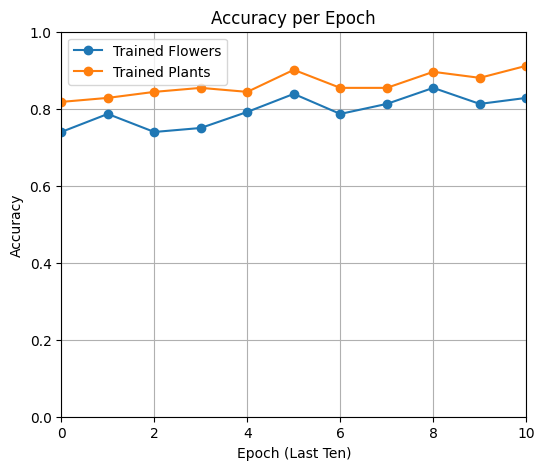

In [ ]:
import matplotlib.pyplot as plt

# Extract the accuracy values per epoch
accuracy_flowers = history_flowers.history['categorical_accuracy'][0:11]
accuracy_plants = history_plants.history['categorical_accuracy'][0:11]

# Create the line graph
plt.figure(figsize=(6, 5))
plt.plot(range(0, 11), accuracy_flowers, label='Trained Flowers', marker='o')
plt.plot(range(0, 11), accuracy_plants, label='Trained Plants', marker='o')
plt.xlabel('Epoch (Last Ten)')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.ylim(0,1)
plt.xlim(0,10)
plt.grid(True)
plt.show()

In [ ]:
average_accuracy_flowers = sum(accuracy_flowers) / len(accuracy_flowers)
average_accuracy_plants = sum(accuracy_plants) / len(accuracy_plants)

print(f'Average accuracy per epoch for Flowers: {average_accuracy_flowers * 100:.2f}%')
print(f'Average accuracy per epoch for Plants: {average_accuracy_plants * 100:.2f}%')

Average accuracy per epoch for Flowers: 79.45%
Average accuracy per epoch for Plants: 86.22%


Examining the Predictions

Now that we have a well-trained model, it is time to create our doggy door for Bo! We can start by looking at the predictions that come from the model. We will preprocess the image in the same way we did for our last doggy door.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model_plant.predict(image)
    return preds

Now we must test if the predictions are correct. Use either 'images to predict' or 'test' folders.

1/1 [==============================] - 1s 508ms/step
The predicted class is: Mango healthy (P0a)


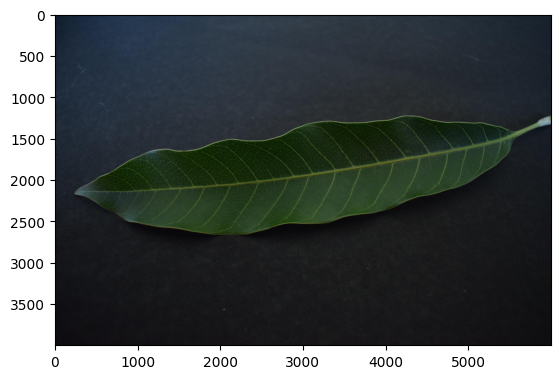

In [ ]:
import numpy as np

# Get the index of the highest probability
predicted_class_index = np.argmax(make_predictions('/content/data/plants/test/Mango healthy (P0a)/0001_0002.JPG'))

# Handles both flowers and plants classes
class_labels = train_plants.class_indices
predicted_class_label = [k for k, v in class_labels.items() if v == predicted_class_index][0]

print(f'The predicted class is: {predicted_class_label}')